# Selection

## Prep env and read in data

get phased info (run beagle notebook if necessary)

### Prep Python

In [9]:
import os
import shutil
from IPython.display import Image
import rpy2.ipython
import allel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Prep R

In [25]:
%%R

library(ggplot2)
library(svglite)
library(ggpubr)


R[write to console]: Loading required package: magrittr



In [11]:
%%R

def_par<-par()

chr_colors <- c("SM_V7_1"    = "cadetblue", 
                "SM_V7_2"    = "darkslategray", 
                "SM_V7_3"    = "cadetblue", 
                "SM_V7_4"    = "darkslategray", 
                "SM_V7_5"    = "cadetblue", 
                "SM_V7_6"    = "darkslategray", 
                "SM_V7_7"    = "cadetblue", 
                "SM_V7_ZW"   = "darkslategray", 
                "SM_V7_MITO" = "cadetblue")

pop_colors <- c("west_africa"   = "red",
                "east_africa"   = "yellow", 
                "new_world"     = "green")

#-------------------------------------------------------------------------------------------------
#function to get cumulative positions for manhattan style plots
#  takes in a "SM_V7?" style chromosome name and outputs the "cumulative position" of that site


#set chromosome lengths
chr_lengths <- c( "SM_V7_1"    =  88881357,
                  "SM_V7_2"    =  48130368,
                  "SM_V7_3"    =  50458499,
                  "SM_V7_4"    =  47279781,
                  "SM_V7_5"    =  25256119,
                  "SM_V7_6"    =  24989083,
                  "SM_V7_7"    =  19288021,
                  "SM_V7_ZW"   =  88385488,
                  "SM_V7_MITO" =  26917      )

#get starting (cumulative start) per chromosome
cumul_starts <- vector()
cumul_starts["SM_V7_1"]    <- 0
cumul_starts["SM_V7_2"]    <- cumul_starts["SM_V7_1"]  + chr_lengths["SM_V7_1"]
cumul_starts["SM_V7_3"]    <- cumul_starts["SM_V7_2"]  + chr_lengths["SM_V7_2"]
cumul_starts["SM_V7_4"]    <- cumul_starts["SM_V7_3"]  + chr_lengths["SM_V7_3"]
cumul_starts["SM_V7_5"]    <- cumul_starts["SM_V7_4"]  + chr_lengths["SM_V7_4"]
cumul_starts["SM_V7_6"]    <- cumul_starts["SM_V7_5"]  + chr_lengths["SM_V7_5"]
cumul_starts["SM_V7_7"]    <- cumul_starts["SM_V7_6"]  + chr_lengths["SM_V7_6"]
cumul_starts["SM_V7_ZW"]   <- cumul_starts["SM_V7_7"]  + chr_lengths["SM_V7_7"]
cumul_starts["SM_V7_MITO"] <- cumul_starts["SM_V7_ZW"] + chr_lengths["SM_V7_ZW"]

get_cumul_pos <- function(chrom, pos){
    #empty the cumul_pos vector
    cumul_pos<-vector()
    
    for(i in seq(1, length(pos))){    

        if ( chrom[i] == "SM_V7_1" ) {
               start <- cumul_starts["SM_V7_1"]
           } else if ( chrom[i] == "SM_V7_2" ) {
               start <-cumul_starts["SM_V7_2"]
           } else if ( chrom[i] == "SM_V7_3" ) {
               start <- cumul_starts["SM_V7_3"]
           } else if ( chrom[i] == "SM_V7_4" ) {
               start <- cumul_starts["SM_V7_4"]
           } else if ( chrom[i] == "SM_V7_5" ) {
               start <- cumul_starts["SM_V7_5"]
           } else if ( chrom[i] == "SM_V7_6" ) {
               start <- cumul_starts["SM_V7_6"]
           } else if ( chrom[i] == "SM_V7_7" ) {
               start <- cumul_starts["SM_V7_7"]
           } else if ( chrom[i] == "SM_V7_ZW" ) {
               start <- cumul_starts["SM_V7_ZW"]
           } else if ( chrom[i] == "SM_V7_MITO" ) {
               start <- cumul_starts["SM_V7_MITO"]
           } else {
              print("ERROR UNRECOGNIZED CHR")
           }
        #set cul position for site
        cumul_pos[i]<-pos[i] +  start
    }
    return(cumul_pos)

}

# #was trying to get a more effiecientfunction but kept having issues with starts from chrZW and mito being
# #   being switched.
# get_cumul_pos <- function(chrom, pos){
#     #empty the cumul_pos vector
#     cumul_pos<-vector()
#     test<-vector()

#     #for each position
#     for( i in seq(1, length(chrom))){
#         #print(cumul_starts)
#         #add the position plus cumulitive start
#         cumul_pos[i] <- cumul_starts[chrom[i]] + pos[i]
#         print(paste(i, chrom[i], pos[i], cumul_starts[chrom[i]], cumul_pos[i], sep=" "))
#     }
#    
#     return(cumul_pos)
#    
# }

In [12]:
%%R

starts<-c(     0,      162219, 241121,  321602, 397183, 421864, 453741)
stops <-c(162218,      241120, 321601,  397182, 421863, 453740, 475073)

names(starts)<-c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7")
names(stops) <-c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7")

### Read in *PHASED* VCF Data

In [13]:
population_assignments = {
    "ERX284221"               : "other",
    "ERR310938"               : "rodhaini",
    "Sro_female_1.1_CCATCCTC" : "rodhaini",
    "Sro_female_1.2_CCGACAAC" : "rodhaini",
    "Sro_female_2.1_CCTAATCC" : "rodhaini",
    "Sro_female_2.2_CCTCTATC" : "rodhaini",
    "Sro_male_1.1_ATCATTCC"   : "rodhaini",
    "Sro_male_1.2_ATTGGCTC"   : "rodhaini",
    "Sro_male_2.1_CAAGGAGC"   : "rodhaini",
    "Sro_male_2.2_CACCTTAC"   : "rodhaini",
    "ERR046038"               : "other",
    "ERR539847"               : "other",
    "ERR539848"               : "other",
    "Sm.BR_PdV.0447.1"        : "new_world",
    "Sm.BR_PdV.1039.1"        : "new_world",
    "Sm.BR_PdV.1079.1"        : "new_world",
    "Sm.BR_PdV.1094.1"        : "new_world",
    "Sm.BR_PdV.1103.1"        : "new_world",
    "Sm.BR_PdV.1127.1"        : "new_world",
    "Sm.BR_PdV.1278.1"        : "new_world",
    "Sm.BR_PdV.1340.1"        : "new_world",
    "Sm.BR_PdV.1340.2"        : "new_world",
    "Sm.BR_PdV.1371.1"        : "new_world",
    "Sm.BR_PdV.1404.1"        : "new_world",
    "Sm.BR_PdV.1409.1"        : "new_world",
    "Sm.BR_PdV.1418.1"        : "new_world",
    "Sm.BR_PdV.1475.1"        : "new_world",
    "Sm.BR_PdV.1489.1"        : "new_world",
    "Sm.BR_PdV.2039.1"        : "new_world",
    "Sm.BR_PdV.2039.2"        : "new_world",
    "Sm.BR_PdV.2072.1"        : "new_world",
    "Sm.BR_PdV.2074.1"        : "new_world",
    "Sm.BR_PdV.2076.1"        : "new_world",
    "Sm.BR_PdV.2133.1"        : "new_world",
    "Sm.BR_PdV.2147.1"        : "new_world",
    "Sm.BR_PdV.2189.1"        : "new_world",
    "Sm.BR_PdV.2196.2"        : "new_world",
    "Sm.BR_PdV.2225.1"        : "new_world",
    "Sm.BR_PdV.2227.1"        : "new_world",
    "Sm.BR_PdV.2265.1"        : "new_world",
    "Sm.BR_PdV.2290.1"        : "new_world",
    "Sm.BR_PdV.2300.1"        : "new_world",
    "Sm.BR_PdV.2334.1"        : "new_world",
    "Sm.BR_PdV.2368.1"        : "new_world",
    "Sm.BR_PdV.2406.1"        : "new_world",
    "Sm.BR_PdV.2422.1"        : "new_world",
    "Sm.BR_PdV.2450.1"        : "new_world",
    "Sm.BR_PdV.2456.1"        : "new_world",
    "Sm.BR_PdV.2481.1"        : "new_world",
    "Sm.BR_PdV.2489.1"        : "new_world",
    "Sm.BR_PdV.2508.1"        : "new_world",
    "Sm.BR_PdV.2516.2"        : "new_world",
    "Sm.BR_PdV.2530.1"        : "new_world",
    "Sm.BR_PdV.2538.1"        : "new_world",
    "Sm.BR_PdV.2546.1"        : "new_world",
    "Sm.BR_PdV.2556.1"        : "new_world",
    "Sm.BR_PdV.2577.1"        : "new_world",
    "Sm.BR_PdV.4293.2"        : "new_world",
    "ERR103050"               : "other",
    "Sm.NE_Di158.1"           : "west_africa",
    "Sm.NE_Di186.1"           : "west_africa",
    "Sm.NE_Di238.1"           : "west_africa",
    "Sm.NE_Di297.1"           : "west_africa",
    "Sm.NE_Di297.2"           : "west_africa",
    "Sm.NE_Di68.2"            : "west_africa",
    "Sm.NE_Na376.2"           : "west_africa",
    "Sm.NE_Na381.1"           : "west_africa",
    "Sm.NE_Na39.1"            : "west_africa",
    "Sm.NE_Na40.1"            : "west_africa",
    "ERR103049"               : "west_africa",
    "Sm.SN_Nd103.1"           : "west_africa",
    "Sm.SN_Nd109.1"           : "west_africa",
    "Sm.SN_Nd114.1"           : "west_africa",
    "Sm.SN_Nd115.1"           : "west_africa",
    "Sm.SN_Nd18.1"            : "west_africa",
    "Sm.SN_Nd22.1"            : "west_africa",
    "Sm.SN_Nd24.1"            : "west_africa",
    "Sm.SN_Nd25.1"            : "west_africa",
    "Sm.SN_Nd34.1"            : "west_africa",
    "Sm.SN_Nd43.1"            : "west_africa",
    "Sm.SN_Nd47.1"            : "west_africa",
    "Sm.SN_Nd5.1"             : "west_africa",
    "Sm.SN_Nd5.2"             : "west_africa",
    "Sm.SN_Nd50.1"            : "west_africa",
    "Sm.SN_Nd54.1"            : "west_africa",
    "Sm.SN_Nd56.1"            : "west_africa",
    "Sm.SN_Nd77.1"            : "west_africa",
    "Sm.SN_Nd79.1"            : "west_africa",
    "Sm.SN_Nd9.1"             : "west_africa",
    "Sm.SN_Nd90.1"            : "west_africa",
    "Sm.SN_Te26.1"            : "west_africa",
    "Sm.SN_Te3.1"             : "west_africa",
    "Sm.SN_Te49.1"            : "west_africa",
    "Sm.SN_Te55.1"            : "west_africa",
    "Sm.SN_Te68.1"            : "west_africa",
    "ERR119614"               : "other",
    "ERR119615"               : "other",
    "ERR997461"               : "other",
    "Sm.TZ_009.1.1"           : "east_africa",
    "Sm.TZ_009.10.1"          : "east_africa",
    "Sm.TZ_009.2.2"           : "east_africa",
    "Sm.TZ_009.3.1"           : "east_africa",
    "Sm.TZ_009.4.2"           : "east_africa",
    "Sm.TZ_009.5.2"           : "east_africa",
    "Sm.TZ_009.6.1"           : "east_africa",
    "Sm.TZ_009.7.1"           : "east_africa",
    "Sm.TZ_009.8.2"           : "east_africa",
    "Sm.TZ_009.9.1"           : "east_africa",
    "Sm.TZ_055.1.3"           : "east_africa",
    "Sm.TZ_055.10.1"          : "east_africa",
    "Sm.TZ_055.2.1"           : "east_africa",
    "Sm.TZ_055.3.2"           : "east_africa",
    "Sm.TZ_055.5.1"           : "east_africa",
    "Sm.TZ_055.6.1"           : "east_africa",
    "Sm.TZ_055.7.1"           : "east_africa",
    "Sm.TZ_055.8.1"           : "east_africa",
    "Sm.TZ_074N.1.2"          : "east_africa",
    "Sm.TZ_074N.10.2"         : "east_africa",
    "Sm.TZ_074N.2.2"          : "east_africa",
    "Sm.TZ_074N.3.2"          : "east_africa",
    "Sm.TZ_074N.4.1"          : "east_africa",
    "Sm.TZ_074N.6.3"          : "east_africa",
    "Sm.TZ_074N.7.2"          : "east_africa",
    "Sm.TZ_074N.8.1"          : "east_africa",
    "Sm.TZ_074N.9.1"          : "east_africa",
    "Sm.TZ_077.2.1"           : "east_africa",
    "Sm.TZ_077.3.1"           : "east_africa",
    "Sm.TZ_077.4.2"           : "east_africa",
    "Sm.TZ_077.5.1"           : "east_africa",
    "Sm.TZ_077.6.1"           : "east_africa",
    "Sm.TZ_077.7.3"           : "east_africa",
    "Sm.TZ_077.8.1"           : "east_africa",
    "Sm.TZ_077.9.2"           : "east_africa",
    "Sm.TZ_086.1.1"           : "east_africa",
    "Sm.TZ_086.2.3"           : "east_africa",
    "Sm.TZ_086.3.1"           : "east_africa",
    "Sm.TZ_086.4.2"           : "east_africa",
    "Sm.TZ_086.5.1"           : "east_africa",
    "Sm.TZ_086.6.1"           : "east_africa",
    "Sm.TZ_086.7.1"           : "east_africa",
    "Sm.TZ_086.8.1"           : "east_africa",
    "Sm.TZ_134.1.1"           : "east_africa",
    "Sm.TZ_134.2.2"           : "east_africa",
    "Sm.TZ_134.4.1"           : "east_africa",
    "Sm.TZ_134.5.1"           : "east_africa",
    "Sm.TZ_134.6.1"           : "east_africa",
    "Sm.TZ_141.1.1"           : "east_africa",
    "Sm.TZ_141.3.1"           : "east_africa",
    "Sm.TZ_141.4.2"           : "east_africa",
    "Sm.TZ_141.5.3"           : "east_africa",
    "Sm.TZ_141.6.1"           : "east_africa",
    "Sm.TZ_141.7.1"           : "east_africa",
    "Sm.TZ_141.8.1"           : "east_africa",
    "Sm.BR_PdV.1409_rep"      : "replicate",
    "Sm.BR_PdV.1475_rep"      : "replicate",
    "Sm.BR_PdV.2406_rep"      : "replicate" }


In [14]:
ids = [ "ERR310938",               "Sro_female_1.1_CCATCCTC", "Sro_female_1.2_CCGACAAC",
        "Sro_female_2.1_CCTAATCC", "Sro_female_2.2_CCTCTATC", "Sro_male_1.1_ATCATTCC",
        "Sro_male_1.2_ATTGGCTC",   "Sro_male_2.1_CAAGGAGC",   "Sro_male_2.2_CACCTTAC",
        "ERR046038",               "ERR539847",               "ERR539848",
        "Sm.BR_PdV.0447.1",        "Sm.BR_PdV.1039.1",        "Sm.BR_PdV.1079.1",
        "Sm.BR_PdV.1094.1",        "Sm.BR_PdV.1103.1",        "Sm.BR_PdV.1127.1",
        "Sm.BR_PdV.1278.1",        "Sm.BR_PdV.1340.1",        "Sm.BR_PdV.1340.2",
        "Sm.BR_PdV.1371.1",        "Sm.BR_PdV.1404.1",        "Sm.BR_PdV.1409.1",
        "Sm.BR_PdV.1409_rep",      "Sm.BR_PdV.1418.1",        "Sm.BR_PdV.1475.1",
        "Sm.BR_PdV.1475_rep",      "Sm.BR_PdV.1489.1",        "Sm.BR_PdV.2039.1",
        "Sm.BR_PdV.2039.2",        "Sm.BR_PdV.2072.1",        "Sm.BR_PdV.2074.1",
        "Sm.BR_PdV.2076.1",        "Sm.BR_PdV.2133.1",        "Sm.BR_PdV.2147.1",
        "Sm.BR_PdV.2189.1",        "Sm.BR_PdV.2196.2",        "Sm.BR_PdV.2225.1",
        "Sm.BR_PdV.2227.1",        "Sm.BR_PdV.2265.1",        "Sm.BR_PdV.2290.1",
        "Sm.BR_PdV.2300.1",        "Sm.BR_PdV.2334.1",        "Sm.BR_PdV.2368.1",
        "Sm.BR_PdV.2406.1",        "Sm.BR_PdV.2406_rep",      "Sm.BR_PdV.2422.1",
        "Sm.BR_PdV.2450.1",        "Sm.BR_PdV.2456.1",        "Sm.BR_PdV.2481.1",
        "Sm.BR_PdV.2489.1",        "Sm.BR_PdV.2508.1",        "Sm.BR_PdV.2516.2",
        "Sm.BR_PdV.2530.1",        "Sm.BR_PdV.2538.1",        "Sm.BR_PdV.2546.1",
        "Sm.BR_PdV.2556.1",        "Sm.BR_PdV.2577.1",        "Sm.BR_PdV.4293.2",
        "ERR103050",               "Sm.NE_Di158.1",           "Sm.NE_Di186.1",
        "Sm.NE_Di238.1",           "Sm.NE_Di297.1",           "Sm.NE_Di297.2",
        "Sm.NE_Di68.2",            "Sm.NE_Na376.2",           "Sm.NE_Na381.1",
        "Sm.NE_Na39.1",            "Sm.NE_Na40.1",            "ERR103049",
        "Sm.SN_Nd103.1",           "Sm.SN_Nd109.1",           "Sm.SN_Nd114.1",
        "Sm.SN_Nd115.1",           "Sm.SN_Nd18.1",            "Sm.SN_Nd22.1",
        "Sm.SN_Nd24.1",            "Sm.SN_Nd25.1",            "Sm.SN_Nd34.1",
        "Sm.SN_Nd43.1",            "Sm.SN_Nd47.1",            "Sm.SN_Nd5.1",
        "Sm.SN_Nd5.2",             "Sm.SN_Nd50.1",            "Sm.SN_Nd54.1",
        "Sm.SN_Nd56.1",            "Sm.SN_Nd77.1",            "Sm.SN_Nd79.1",
        "Sm.SN_Nd9.1",             "Sm.SN_Nd90.1",            "Sm.SN_Te26.1",
        "Sm.SN_Te3.1",             "Sm.SN_Te49.1",            "Sm.SN_Te55.1",
        "Sm.SN_Te68.1",            "ERR119614",               "ERR119615",
        "ERR997461",               "Sm.TZ_009.1.1",           "Sm.TZ_009.10.1",
        "Sm.TZ_009.2.2",           "Sm.TZ_009.3.1",           "Sm.TZ_009.4.2",
        "Sm.TZ_009.5.2",           "Sm.TZ_009.6.1",           "Sm.TZ_009.7.1",
        "Sm.TZ_009.8.2",           "Sm.TZ_009.9.1",           "Sm.TZ_055.1.3",
        "Sm.TZ_055.10.1",          "Sm.TZ_055.2.1",           "Sm.TZ_055.3.2",
        "Sm.TZ_055.5.1",           "Sm.TZ_055.6.1",           "Sm.TZ_055.7.1",
        "Sm.TZ_055.8.1",           "Sm.TZ_074N.1.2",          "Sm.TZ_074N.10.2",
        "Sm.TZ_074N.2.2",          "Sm.TZ_074N.3.2",          "Sm.TZ_074N.4.1",
        "Sm.TZ_074N.6.3",          "Sm.TZ_074N.7.2",          "Sm.TZ_074N.8.1",
        "Sm.TZ_074N.9.1",          "Sm.TZ_077.2.1",           "Sm.TZ_077.3.1",
        "Sm.TZ_077.4.2",           "Sm.TZ_077.5.1",           "Sm.TZ_077.6.1",
        "Sm.TZ_077.7.3",           "Sm.TZ_077.8.1",           "Sm.TZ_077.9.2",
        "Sm.TZ_086.1.1",           "Sm.TZ_086.2.3",           "Sm.TZ_086.3.1",
        "Sm.TZ_086.4.2",           "Sm.TZ_086.5.1",           "Sm.TZ_086.6.1",
        "Sm.TZ_086.7.1",           "Sm.TZ_086.8.1",           "Sm.TZ_134.1.1",
        "Sm.TZ_134.2.2",           "Sm.TZ_134.4.1",           "Sm.TZ_134.5.1",
        "Sm.TZ_134.6.1",           "Sm.TZ_141.1.1",           "Sm.TZ_141.3.1",
        "Sm.TZ_141.4.2",           "Sm.TZ_141.5.3",           "Sm.TZ_141.6.1",
        "Sm.TZ_141.7.1",           "Sm.TZ_141.8.1" ]

vcf_sample_idxs={}
vcf_sample_idxs["new_world"]=list(range(12,24)) + list(range(25,27)) + list(range(28,46)) + list(range(47,60)) 
vcf_sample_idxs["west_africa"]=list(range(61,71)) + list(range(72, 97)) 
vcf_sample_idxs["east_africa"]=list(range(100,155))

In [15]:
#read in PHASED vcf
phased_callset=allel.read_vcf('results/phasing/auto_beagle.vcf')

#after reading in the vcf file get a idx of the chrom and pos for each variant
chrom=phased_callset['variants/CHROM']
pos=phased_callset['variants/POS']
idx=allel.ChromPosIndex(chrom, pos)

#get genotypes
phased_g=phased_callset['calldata/GT']
gt=allel.GenotypeArray(phased_g)

### Calculate pop and chr specific info

In [16]:
#now get pop specific acs

#get list of gtd samples
samples=list(phased_callset["samples"])

pops=["east_africa", "west_africa", "new_world", "rodhaini", "other", "replicate"]

#initialize dictionary
pop_idxs={}
for pop in pops:
    pop_idxs[pop]=[]
    
#iterate over samples and add the index to a population specific dictionary (pop_idxs)
i=0
for sample in samples:
    pop_assignment=population_assignments[sample]

    pop_idxs[pop_assignment].append(i)
    
    i=i+1

#now calculate that pop allele counts (ac), genotype (gc), and haplotypes (h)
pop_ac={}
pop_ac_maf05={}
pop_ac_mac1={}

pop_gt={}
pop_gt_mac1={}
pop_gt_maf05={}

pop_h={}
pop_h_mac1={}
pop_h_maf05={}

mac1_idx={}
maf05_idx={}

start_chr_idxs={}
stop_chr_idxs={}

mac1_idx={}
mac1_chrom={}
mac1_pos={}
mac1_start_chr_idxs={}
mac1_stop_chr_idxs={}

maf05_idx={}
maf05_chrom={}
maf05_pos={}
maf05_start_chr_idxs={}
maf05_stop_chr_idxs={}


for pop in ["new_world", "east_africa", "west_africa"]:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])
    
    #calculate acs by excluding with maf and mac
    maf=pop_ac[pop][:, :2].min(axis=1)/pop_ac[pop][:, :2].sum(axis=1)
    pop_ac_maf05[pop]=pop_ac[pop][maf>0.05]
    maf05_idx[pop]=idx[maf>0.05]
    
    #get mac1s for each pop
    mac1=pop_ac[pop].max_allele()==1
    pop_ac_mac1[pop]=pop_ac[pop][mac1]
    mac1_idx[pop]=idx[mac1]
    
    #get all gts
    pop_gt[pop]       = gt.take(pop_idxs[pop], axis=1)
    pop_gt_maf05[pop] = gt[maf>0.05].take(pop_idxs[pop], axis=1)
    pop_gt_mac1[pop]  = gt[mac1].take(pop_idxs[pop], axis=1)
    
    #get all hs
    pop_h[pop]  = pop_gt[pop].to_haplotypes()
    pop_h_maf05[pop]= pop_gt_maf05[pop].to_haplotypes()
    pop_h_mac1[pop]= pop_gt_mac1[pop].to_haplotypes()

    #get pos data
    mac1_chrom[pop]=phased_callset['variants/CHROM'][mac1]
    mac1_pos[pop]=phased_callset['variants/POS'][mac1]
    mac1_idx[pop]=allel.ChromPosIndex(mac1_chrom[pop], mac1_pos[pop])

    #maf pos data
    maf05_chrom[pop]=phased_callset['variants/CHROM'][maf>0.05]
    maf05_pos[pop]=phased_callset['variants/POS'][maf>0.05]
    maf05_idx[pop]=allel.ChromPosIndex(maf05_chrom[pop], maf05_pos[pop])
    
    mac1_start_chr_idxs[pop]={}
    mac1_stop_chr_idxs[pop]={}
    maf05_start_chr_idxs[pop]={}
    maf05_stop_chr_idxs[pop]={}
    #get the chrom, pos, and idx for mac and maf
    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:    
        #mac
        itemindex = list(np.where(mac1_chrom[pop]==chr)[0])
        mac1_start_chr_idxs[pop][chr]=int(itemindex[0])
        mac1_stop_chr_idxs[pop][chr]=int(itemindex[-1])

        itemindex = list(np.where(maf05_chrom[pop]==chr)[0])
        maf05_start_chr_idxs[pop][chr]=int(itemindex[0])
        maf05_stop_chr_idxs[pop][chr]=int(itemindex[-1])


      
        
#get the first and last position for each chr based on the idx
for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
    itemindex = list(np.where(chrom==chr)[0])
    start_chr_idxs[chr]=int(itemindex[0])
    stop_chr_idxs[chr]=int(itemindex[-1])


In [17]:
#set window of bp to test sel
window=100_000

#define an array of window start and stops
window_starts = [int(x - (window/2)) for x in pos]
window_stops  = [int(x + (window/2)) for x in pos]

#make sure that window starts are all gt 1
window_starts = [1 if i < 1 else i for i in window_starts]

#make sure that all stops are not gt chrom length
chr_length={}
chr_length["SM_V7_1"] = 88_881_357
chr_length["SM_V7_2"] = 48_130_368
chr_length["SM_V7_3"] = 50_458_499
chr_length["SM_V7_4"] = 47_279_781
chr_length["SM_V7_5"] = 25_256_119
chr_length["SM_V7_6"] = 24_989_083
chr_length["SM_V7_7"] = 19_288_021

i=0
for stop in window_stops:
    stop_chr=chrom[i]
    
    if stop > chr_length[stop_chr]:
        window_stops[i]=chr_length[stop_chr]
    i=i+1


window_starts=np.array(window_starts)
window_stops=np.array(window_stops)

windows=np.column_stack((window_starts, window_stops))

maf05_window_starts = window_starts[maf>0.05]
maf05_window_stops  = window_stops[maf>0.05]
maf05_windows=np.column_stack((window_starts, window_stops))

In [24]:
windows

array([[  252288,   352288],
       [  655190,   755190],
       [  655210,   755210],
       ...,
       [19037132, 19137132],
       [19037217, 19137217],
       [19037225, 19137225]])

## Single Population Statistics

### Pi

In [63]:
#make a clean dir
if os.path.isdir("results/pi_per_window"):
    shutil.rmtree("results/pi_per_window")
os.mkdir("results/pi_per_window")

In [64]:
#get accessible bases
bait_file = open("data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed", 'r')

#initialize "accessible" arrays to all false
accessible={}
for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
    accessible[chr]=[False]*chr_length[chr]

#for each bait
for bait in bait_file:
    chr, start, stop = bait.split("\t")
    
    #if it is on an autosome
    if chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
        #add "true" at each site int he bait file
        for site in list(range(int(start)-1, int(stop))):
            accessible[chr][site]=True

In [65]:
#use 100kb windows
windows=np.column_stack((window_starts, window_stops))

for population in ["new_world", "east_africa", "west_africa"]:
    
    pi_s              = []
    pi_window_s       = []
    pi_n_accessible_s = []
    pi_count_s        = []

    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:

        #get the positions, windows, and acs for this chromosome
        chrom_pos        = pos[start_chr_idxs[chr]:stop_chr_idxs[chr]]
        chrom_windows    = windows[start_chr_idxs[chr]:stop_chr_idxs[chr]]
        chrom_ac         = pop_ac[population][start_chr_idxs[chr]:stop_chr_idxs[chr]]
        chrom_accessible = accessible[chr]
        
        pi, window, n_accessible, count = allel.windowed_diversity(chrom_pos, 
                                                                           chrom_ac, 
                                                                           windows       = chrom_windows, 
                                                                           is_accessible = chrom_accessible)

        #combine into a single list
        pi_s              = pi_s              + list(pi)
        pi_window_s       = pi_window_s       + list(window)
        pi_n_accessible_s = pi_n_accessible_s + list(n_accessible)
        pi_count_s        = pi_count_s        + list(count)
        
    #save list to a file (maybe plot)
    with open("results/pi_per_window/" + population + "_pi_+-50kb.csv", 'w') as pi_file:
        i=0

        pi_file.write("chrom,pos,pi,window_start,window_stop,n_accessible_bases,snp_count\n")
        while i < len(pi_s):
            out_line = "{chrom},{pos},{pi},{start},{stop},{access},{count}\n".format(chrom  = chrom[i],
                                                                                     pos    = str(pos[i]),
                                                                                     pi     = pi_s[i],
                                                                                     start  = pi_window_s[i][0],
                                                                                     stop   = pi_window_s[i][1],
                                                                                     access = pi_n_accessible_s[i],
                                                                                     count  = pi_count_s[i] )
            
            pi_file.write(out_line)
            i=i+1
            

In [66]:
%%R

smoothed_k<-21

pi_plots<-vector("list", 3)
names(pi_plots)<-c("east_africa", "west_africa", "new_world")

#smooth the pi for each chromosome and output a single smoothed file
for (pop in c("east_africa", "west_africa", "new_world")) {

    #make output file name
    in_file  <- paste("results/pi_per_window/",  pop, "_pi_+-50kb.csv",  sep="")

    out          <- paste("results/pi_per_window/",  pop, "_pi_+-50kb_smoothed", smoothed_k,  sep="")
    out_csv      <- paste(out, ".csv", sep="")
    out_png      <- paste(out, ".png", sep="")
    out_svg      <- paste(out, ".svg", sep="")    
    out_slim_png <- paste(out, "_slim.png", sep="")

    
    pi_table <- read.table(in_file, header=TRUE, sep=",")
    pop_smoothed_pis <- c()

    #seperate out chromosomes

    for ( CHROM in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
        chr_start <- starts[[CHROM]] + 1
        chr_stop  <- stops[[CHROM]]  + 1

        #get chr pi
        chr_pi <- pi_table$pi[chr_start:chr_stop]

        #smooth
        smoothed_chr_pi<-runmed(chr_pi, smoothed_k, endrule="median")

        #add to list
        pop_smoothed_pis <- c(pop_smoothed_pis, smoothed_chr_pi)

    }


    #save to file
    pi_table$smoothed_pi <- pop_smoothed_pis
    write.csv(pi_table, 
              out_csv, 
              row.names = FALSE,
              quote=FALSE)

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(pi_table$chrom, pi_table$pos)

    p <- ggplot(pi_table, 
                aes(x     = !!cumul_pos, 
                    y     = smoothed_pi, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size=0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("Pi ", pop), 
                                expand = c(0,0),
                                limits = c(0,max(pi_table$smoothed_pi) * 1.2),
                                breaks = seq(0, 1, 0.005) )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank() )

    #modify legend
    p <- p + theme(legend.position = "none")
    
    #save the figure
    pi_plots[[pop]]<-p
    
    ggsave(out_png, plot = p, dpi = 600)
    ggsave(out_svg, plot = p)
    ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

    #===================================================================================
    #print to NB
    #print(p)

}

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



R[write to console]: Saving 6.67 x 6.67 in image



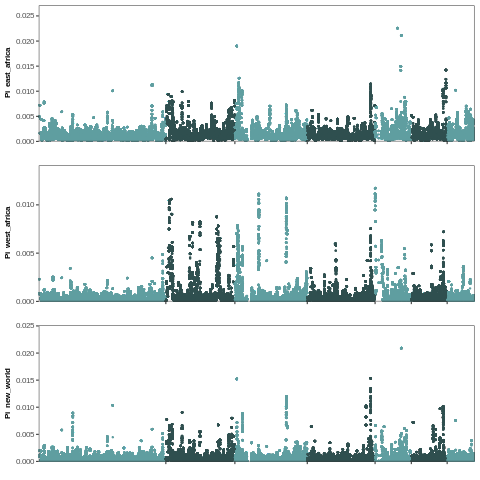

In [73]:
%%R

# pi_plots[["new_world"]], 
# pi_plots[["west_africa"]], 
# pi_plots[["east_africa"]]

plot<-ggarrange(plotlist = pi_plots, 
                ncol = 1, 
                nrow = 3)

print(plot)

ggsave("results/pi_per_window/combined.png", plot = plot, dpi = 1200)

### Tajimas D

In [68]:
#make a clean dir
if os.path.isdir("results/tajimas_d"):
    shutil.rmtree("results/tajimas_d")
os.mkdir("results/tajimas_d")

#create files with lists of samples per population
for sample in population_assignments:
    with open("results/tajimas_d/" + population_assignments[sample] + ".list", 'a') as list_file:
        list_file.write(sample + "\n")
        
os.remove("results/tajimas_d/other.list")
os.remove("results/tajimas_d/replicate.list")
os.remove("results/tajimas_d/rodhaini.list")

In [69]:
#use 100kb windows
windows=np.column_stack((window_starts, window_stops))

for population in ["new_world", "east_africa", "west_africa"]:
    
    tajimasd_s             = []
    tajimasd_calc_window_s = []
    tajimasd_count_s       = []

    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:

        #get the positions, windows, and acs for this chromosome
        chrom_pos     = pos[start_chr_idxs[chr]:stop_chr_idxs[chr]]
        chrom_windows = windows[start_chr_idxs[chr]:stop_chr_idxs[chr]]
        chrom_ac      = pop_ac[population][start_chr_idxs[chr]:stop_chr_idxs[chr]]
        
        
        #calculate td
        td, window, count = allel.windowed_tajima_d(chrom_pos, 
                                                    chrom_ac,
                                                    windows   = chrom_windows, 
                                                    min_sites = 3)

        #combine into a single list
        tajimasd_s             = tajimasd_s + list(td)
        tajimasd_calc_window_s = tajimasd_calc_window_s + list(window)
        tajimasd_count_s       = tajimasd_count_s + list(count)
        
        #account for the last len(k) of each chromosome do not have windows

    #save list to a file (maybe plot)
    with open("results/tajimas_d/" + population + "_tajimas-d_+-50kb.csv", 'w') as td_file:
        i=0

        td_file.write("chrom,pos,tajimasd,window_start,window_stop,snp_count\n")
        while i < len(tajimasd_s):
            out_line = "{chrom},{pos},{td},{start},{stop},{count}\n".format(chrom = chrom[i],
                                                                            pos   = str(pos[i]),
                                                                            td    = tajimasd_s[i],
                                                                            start = tajimasd_calc_window_s[i][0],
                                                                            stop  = tajimasd_calc_window_s[i][1],
                                                                            count = tajimasd_count_s[i] )
            
            td_file.write(out_line)
            i=i+1

In [74]:
%%R

smoothed_k<-21

td_plots       <-vector("list", 3)
names(td_plots)<-c("east_africa", "west_africa", "new_world")


#smooth the tajimasd for each chromosome and output a single smoothed file
for (pop in c("east_africa", "west_africa", "new_world")) {

    #make input and output file names
    in_file  <- paste0("results/tajimas_d/",  pop, "_tajimas-d_+-50kb.csv")

    out <- paste0("results/tajimas_d/",  pop, "_tajimas-d_+-50kb_smoothed", smoothed_k)
  
    out_csv      <- paste(out, ".csv", sep="")
    out_png      <- paste(out, ".png", sep="")
    out_svg      <- paste(out, ".svg", sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")

    td_table <- read.table(in_file, header=TRUE, sep=",")

    #get only complete cases
    td_table <-td_table[complete.cases(td_table), ]

    pop_smoothed_tds <- c()

    #seperate out chromosomes
    for ( CHROM in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
        chr_start <- min(which(td_table$chrom == CHROM))
        chr_stop  <- max(which(td_table$chrom == CHROM))

        #get chr td
        chr_td <- td_table$tajimasd[chr_start:chr_stop]

        #smooth
        smoothed_chr_td<-runmed(chr_td, smoothed_k, endrule="median")

        #add to list
        pop_smoothed_tds <- c(pop_smoothed_tds, smoothed_chr_td)
    }

    #save to file
    td_table$smoothed_td <- pop_smoothed_tds
    write.csv(td_table, 
              out_csv, 
              row.names = FALSE,
              quote     = FALSE)

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(td_table$chrom, td_table$pos)

    p <- ggplot(td_table, 
                aes(x     = !!cumul_pos, 
                    y     = smoothed_td, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("Tajima's D ", pop, sep=""), 
                                expand = c(0,0),
                                limits = c(min(td_table$smoothed_td) * 1.2,
                                           max(td_table$smoothed_td) * 1.2),
                                breaks = seq(-10,10,1),
                                labels = scales::number_format(accuracy     = 0.1, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    ggsave(out_png, plot = p, dpi = 600)
    ggsave(out_svg, plot = p)
    ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)
    
    td_plots[[pop]]<-p
    
    #===================================================================================
    ##print to NB
    #print(p)
}

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



R[write to console]: Saving 6.67 x 6.67 in image



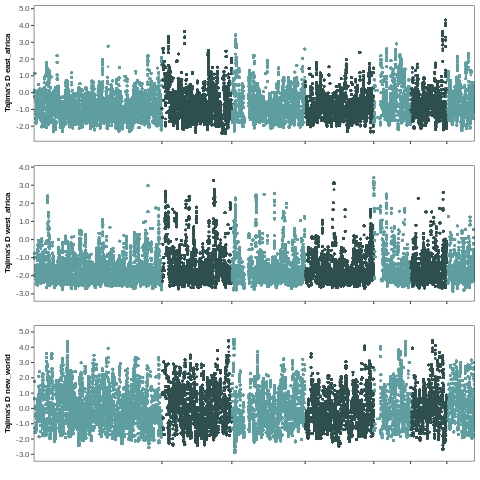

In [75]:
%%R

plot <- ggarrange(plotlist = td_plots, 
                  ncol = 1, 
                  nrow = 3)

print(plot)

ggsave("results/tajimas_d/combined.png", plot = plot, dpi = 1200)


### Garuds H

In [31]:
#allel.garud_h(h)
if os.path.isdir("results/garuds_h"):
    shutil.rmtree("results/garuds_h")
    
os.mkdir("results/garuds_h")

In [32]:
#100kb windows

snp_window_size = 100

for pop in ["new_world", "east_africa", "west_africa"]:

    h1_s       = []
    h12_s      = []
    h123_s     = []
    h2_h1_s    = []
    h_window_s = []
    h_count_s  = []

    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:

        #mac1 pos
        chrom_mac_h   = pop_h_mac1[pop][mac1_start_chr_idxs[pop][chr]:mac1_stop_chr_idxs[pop][chr]]


        h1, h12, h123, h2_h1 = allel.moving_garud_h(chrom_mac_h, 
                                                    snp_window_size, 
                                                    step  = 1)

        #combine into a single list
        h1_s       = h1_s       + list(h1)
        h12_s      = h12_s      + list(h12)
        h123_s     = h123_s     + list(h123)
        h2_h1_s    = h2_h1_s    + list(h2_h1) 

    #save list to a file (maybe plot)
    with open("results/garuds_h/" + pop + "_garuds-h_" + str(snp_window_size) + "-snp-window.csv", 'w') as h_file:
        i = 0

        h_file.write("chrom,pos,h1,h12,h123,h2_h1\n")

        while i < len(h1_s):
            out_line = "{chrom},{pos},{h1},{h12},{h123},{h2_h1}\n".format(chrom = mac1_chrom[pop][i],
                                                                          pos   = str(mac1_pos[pop][i]),
                                                                          h1    = h1_s[i],
                                                                          h12   = h12_s[i],
                                                                          h123  = h123_s[i],
                                                                          h2_h1 = h2_h1_s[i],
                                                                          )

            h_file.write(out_line)
            i = i + 1

In [33]:
%%R

smoothed_k<-21

h1_plots<-vector("list", 3)
names(h1_plots)<-c("east_africa", "new_world", "west_africa")

#smooth the hs for each chromosome and output a single smoothed file
for (pop in c("east_africa", "new_world", "west_africa")) {

    #make input and output file names
    in_file  <- paste("results/garuds_h/",  pop, "_garuds-h_100-snp-window.csv",  sep="")
    
    out <- paste("results/garuds_h/",  pop, "_garuds-h_100-snp-window_smoothed", smoothed_k,  sep="")
    out_csv      <- paste(out, ".csv",      sep="")
    
    out <- paste("results/garuds_h/",  pop, "_garuds-h1_100-snp-window_smoothed", smoothed_k,  sep="")
    out_png      <- paste(out, ".png",      sep="")
    out_svg      <- paste(out, ".svg",      sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")    


    h_table <- read.table(in_file, header=TRUE, sep=",")

    #get only complete cases
    h_table <-h_table[complete.cases(h_table), ]

    pop_smoothed_h1s    <- c()
    pop_smoothed_h12s   <- c()
    pop_smoothed_h123s  <- c()
    pop_smoothed_h2_h1s <- c()

    #seperate out chromosomes
    for ( chrom in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
        chr_start <- min(which(h_table$chrom == chrom))
        chr_stop  <- max(which(h_table$chrom == chrom))

        #get chr h1
        chr_h1    <- h_table$h1[chr_start:chr_stop]
        chr_h12   <- h_table$h12[chr_start:chr_stop]
        chr_h123  <- h_table$h123[chr_start:chr_stop]
        chr_h2_h1 <- h_table$h2_h1[chr_start:chr_stop]

        #smooth
        smoothed_chr_h1    <-runmed(chr_h1,    smoothed_k, endrule="median")
        smoothed_chr_h12   <-runmed(chr_h12,   smoothed_k, endrule="median")
        smoothed_chr_h123  <-runmed(chr_h123,  smoothed_k, endrule="median")
        smoothed_chr_h2_h1 <-runmed(chr_h2_h1, smoothed_k, endrule="median")


        #add to list
        pop_smoothed_h1s    <- c(pop_smoothed_h1s, smoothed_chr_h1)
        pop_smoothed_h12s   <- c(pop_smoothed_h12s, smoothed_chr_h1)
        pop_smoothed_h123s  <- c(pop_smoothed_h123s, smoothed_chr_h1)
        pop_smoothed_h2_h1s <- c(pop_smoothed_h2_h1s, smoothed_chr_h1)

    }

    #save to file
    h_table$smoothed_h1    <- pop_smoothed_h1s
    h_table$smoothed_h12   <- pop_smoothed_h12s
    h_table$smoothed_h123  <- pop_smoothed_h123s
    h_table$smoothed_h2_h1 <- pop_smoothed_h2_h1s


    write.csv(h_table, 
              out_csv, 
              row.names = FALSE,
              quote     = FALSE)

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(h_table$chrom, h_table$pos)

    p <- ggplot(h_table, 
                aes(x     = !!cumul_pos, 
                    y     = smoothed_h1, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("H1", pop, sep=" "), 
                                expand = c(0,0),
                                limits = c(0, 
                                           max(h_table$smoothed_h1) * 1.2),
                                breaks = seq(0,1,0.1),
                                labels = scales::number_format(accuracy     = 0.2, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    h1_plots[[pop]]<-p
    
    #ggsave(out_png, plot = p, dpi = 600)
    #ggsave(out_svg, plot = p)
    #ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

    ##print to NB
    #print(p)
}




R[write to console]: Saving 6.67 x 6.67 in image



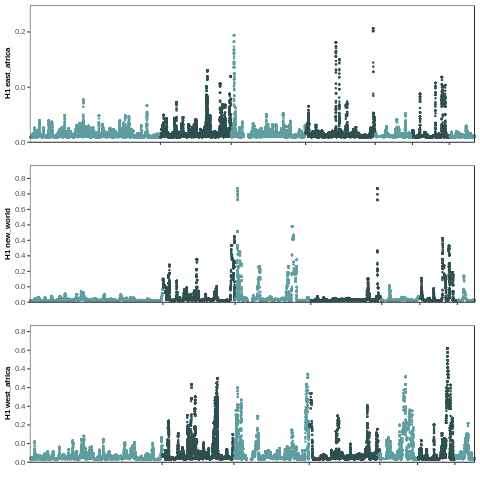

In [34]:
%%R

plot <- ggarrange(plotlist = h1_plots, 
                      ncol = 1, 
                      nrow = 3)

print(plot)

ggsave("results/garuds_h/h1_combined.png", plot = plot, dpi = 1200)


In [35]:
%%R

smoothed_k<-21

h12_plots<-vector("list", 3)
names(h12_plots)<-c("east_africa", "west_africa", "new_world")

#smooth the hs for each chromosome and output a single smoothed file
for (pop in c("east_africa", "west_africa", "new_world")) {

    #make input and output file names
    in_file      <- paste("results/garuds_h/",  pop, "_garuds-h_100-snp-window_smoothed", smoothed_k, ".csv",  sep="")
    out          <- paste("results/garuds_h/",  pop, "_garuds-h12_100-snp-window_smoothed", smoothed_k,  sep="")
    out_png      <- paste(out, ".png",      sep="")
    out_svg      <- paste(out, ".svg",      sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")       
 

    smoothed_h_table <- read.table(in_file, header=TRUE, sep=",")

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(smoothed_h_table$chrom, smoothed_h_table$pos)

    p <- ggplot(smoothed_h_table, 
                aes(x     = !!cumul_pos, 
                    y     = smoothed_h12, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("H12", pop, sep=""), 
                                expand = c(0,0),
                                limits = c(0, max(smoothed_h_table$smoothed_h12) * 1.2),
                                breaks = seq(0, 1, 0.1),
                                labels = scales::number_format(accuracy = 0.1, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    h12_plots[[pop]]<-p

    ggsave(out_png, plot = p, dpi = 600)
    ggsave(out_svg, plot = p)
    ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

    ##print to NB
    #print(p)
}



R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



R[write to console]: Saving 6.67 x 6.67 in image



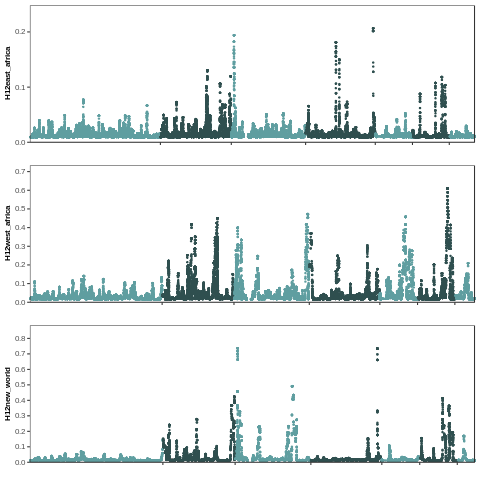

In [36]:
%%R

plot <- ggarrange(plotlist = h12_plots, 
                  ncol = 1, 
                  nrow = 3)

print(plot)

ggsave("results/garuds_h/h12_combined.png", plot = plot, dpi = 1200)


### iHS

iHS (Integrated Haplotype Score) is a statistic that has been developed to detect evidence of recent positive selection at a locus. It is based on the differential levels of linkage disequilibrium(LD) surrounding a positively selected allele compared to the background allele at the same position. An extreme positive iHS score (iHS > 2) means that haplotypes on the ancestral allele background are longer compared to derived allele background. An extreme negative iHS score (iHS < -2) means that the haplotypes on the derived allele background are longer compared to the haplotypes associated with the ancestral allele. Under our model we expect selected derived alleles to harbour excessive LD relative to the background. However, an extreme positive iHS score is also considered as a candidate because the ancetral allele may be hitchhiking along with the selected allele, or the ancestral allele itself may be the target of selection. iHS has the highest power to detect selection when the selected allele has swept to intermediate frequencies. The power of iHS also depends on many other factors such as local SNP density, SNP ascertainment, availability of haplotype phase information and intensity of selection among others. For more detailed information on this statistic and results of a whole genome scan, please refer to our associated publication (Voight et al, 2006).

__For my purposes have taken the abs of the iHS score.__

In [83]:
if os.path.isdir("results/ihs"):
    shutil.rmtree("results/ihs")
os.mkdir("results/ihs")

/master/nplatt/anaconda3/envs/sch_man_nwinvasion-selection/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


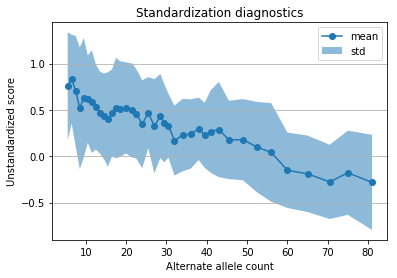

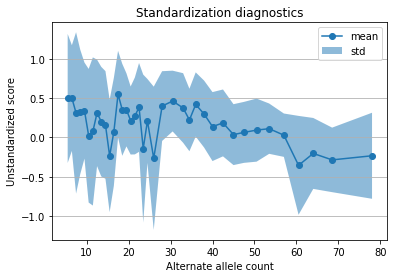

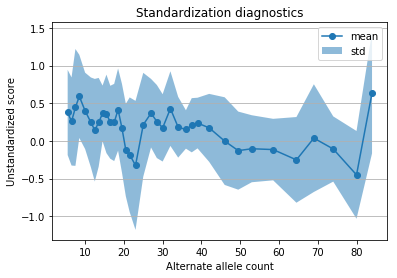

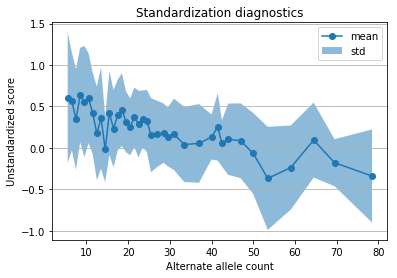

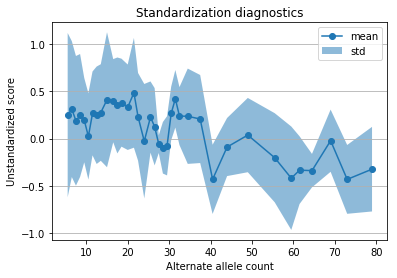

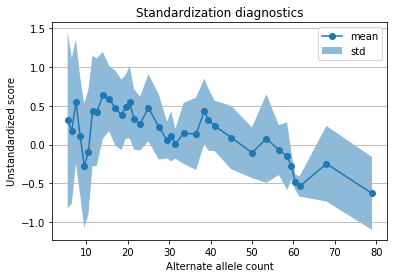

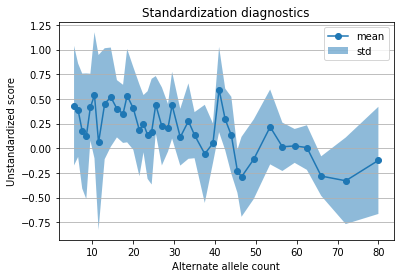

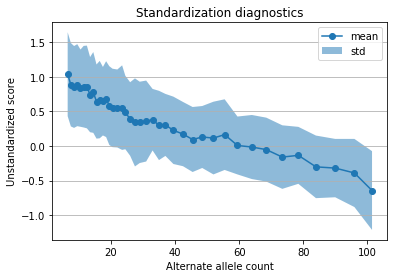

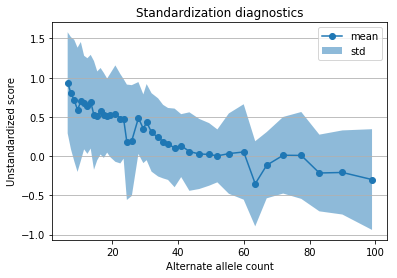

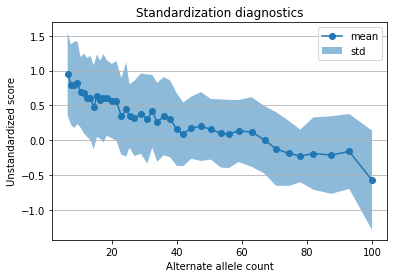

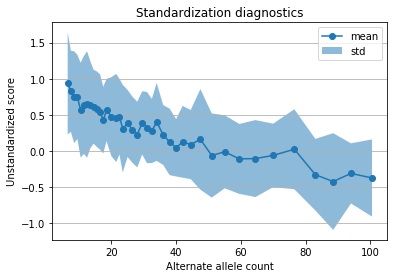

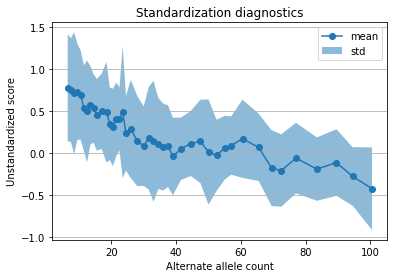

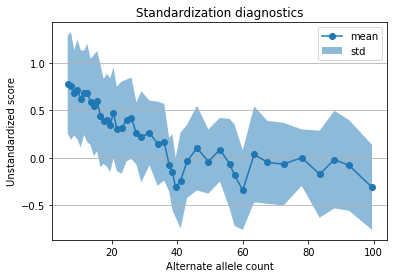

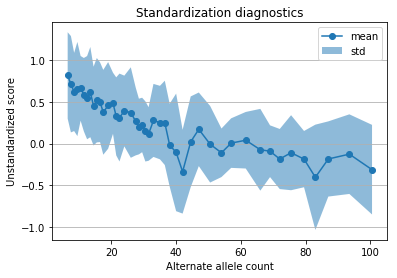

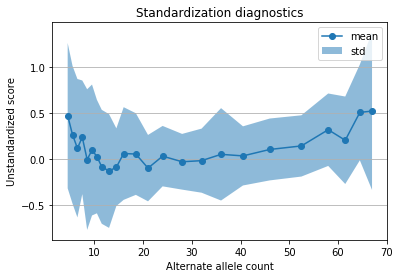

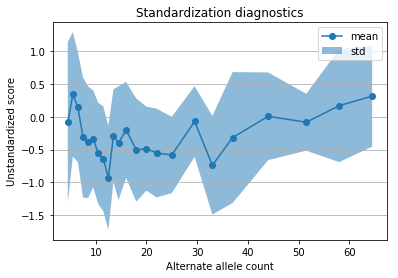

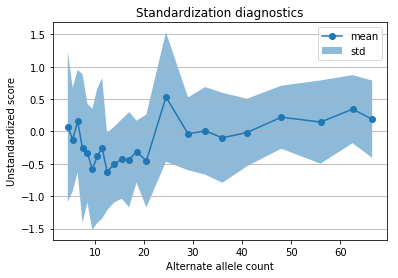

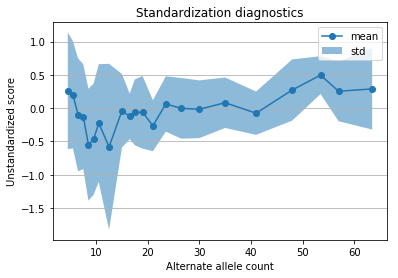

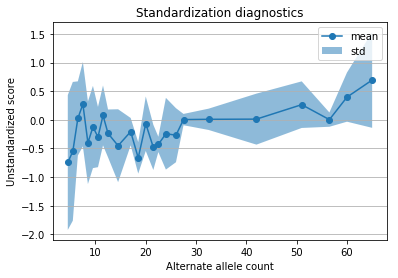

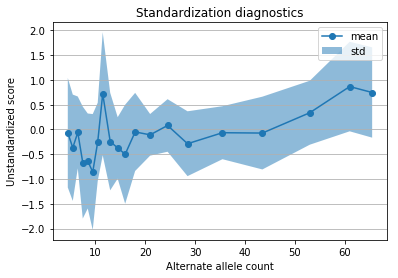

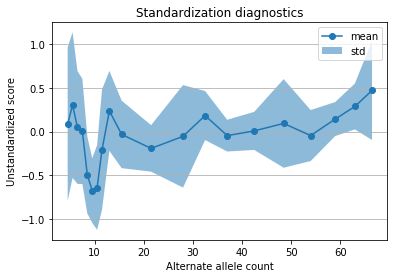

In [84]:
for pop in ["new_world", "east_africa", "west_africa"]:

    ihs_s = []
    sihs_s= []

    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
        
        #need haplotypes, and positions for each site per chromosome so get idxs of start and stop
        start_idx = int(start_chr_idxs[chr]) 
        stop_idx  = int(stop_chr_idxs[chr])
        
        #subset from larger haplotype and pos arrays
        pop_chr_h = pop_h[pop][start_idx:stop_idx+1]
        chr_pos   = pos[start_idx:stop_idx+1]
        
        #calc ihs
        ihs = allel.ihs(pop_chr_h, 
                        chr_pos, 
                        min_ehh       = 0.05, 
                        min_maf       = 0.05, 
                        include_edges = False, 
                        gap_scale     = 20000, 
                        max_gap       = 200000, 
                        is_accessible = None, 
                        use_threads   = True)
                
        ihs_s = ihs_s + list(ihs)
        
        #standardize
        aac=pop_ac[pop][start_idx:stop_idx+1:,1]
        sihs, bins=allel.standardize_by_allele_count(ihs, 
                                                     aac, 
                                                     bins=None, 
                                                     n_bins=None, 
                                                     diagnostics=True)
        
        sihs_s = sihs_s + list(sihs)
        
    #save list to a file (maybe plot)
    with open("results/ihs/" + pop + "_ihs.csv", 'w') as ihs_file:
        i = 0
        
        ihs_file.write("chrom,pos,ihs,sihs\n")
        
        while i < len(idx):
            out_line = "{chrom},{pos},{ihs},{sihs}\n".format( chrom = chrom[i],
                                                              pos   = str(pos[i]),
                                                              ihs   = ihs_s[i],
                                                              sihs  = sihs_s[i])
            ihs_file.write(out_line)
            i = i + 1

In [41]:
%%R

smoothed_k<-21

ihs_plots<-vector("list", 3)
names(ihs_plots)<-c("east_africa", "west_africa", "new_world")

#smooth the hs for each chromosome and output a single smoothed file
for (pop in c("east_africa", "west_africa", "new_world")) {

    #make input and output file names
    in_file  <- paste("results/ihs/",  pop, "_ihs.csv",  sep="")

    out          <- paste("results/ihs/",  pop, "_ihs_smoothed", smoothed_k,  sep="")
    out_csv      <- paste(out, ".csv", sep="")
    out_png      <- paste(out, ".png", sep="")
    out_svg      <- paste(out, ".svg", sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")

    ihs_table <- read.table(in_file, header=TRUE, sep=",")

    #get only complete cases
    ihs_table <-ihs_table[complete.cases(ihs_table), ]

    pop_smoothed_ihss    <- c()

    #seperate out chromosomes
    for ( CHROM in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
        chr_start <- min(which(ihs_table$chrom == CHROM))
        chr_stop  <- max(which(ihs_table$chrom == CHROM))

        #get chr h1
        chr_ihs    <- ihs_table$sihs[chr_start:chr_stop]

        #smooth
        smoothed_chr_ihs    <-runmed(chr_ihs,    smoothed_k, endrule="median")

        #add to list
        pop_smoothed_ihss    <- c(pop_smoothed_ihss, smoothed_chr_ihs)

    }

    #save to file
    ihs_table$smoothed_ihs    <- pop_smoothed_ihss

    write.csv(ihs_table, 
              out_csv, 
              row.names = FALSE,
              quote=FALSE)

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(ihs_table$chrom, ihs_table$pos)

    p <- ggplot(ihs_table, 
                aes(x     = !!cumul_pos, 
                    y     = abs(smoothed_ihs), 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("sihs", pop, sep=" "), 
                                expand = c(0,0),
                                limits = c(0,3.25),
#                                 limits = c(min(ihs_table$smoothed_ihs) * 1.2, 
#                                            max(ihs_table$smoothed_ihs) * 1.2),
                                breaks = seq(-10,10,1),
                                labels = scales::number_format(accuracy = 0.1, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    ihs_plots[[pop]]<-p

    #ggsave(out_png, plot = p, dpi = 600)
    #ggsave(out_svg, plot = p)
    #ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

    ##print to NB
    #print(p)
}



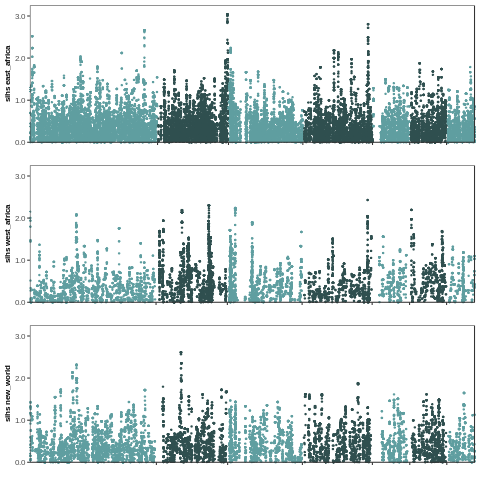

In [42]:
%%R

plot <- ggarrange(plotlist = ihs_plots, 
                  ncol = 1, 
                  nrow = 3)

print(plot)

#ggsave("results/ihs/combined.png", plot = plot, dpi = 1200)

## Multi-population statistics

### FST

In [92]:
if os.path.isdir("results/fst_per_window"):
    shutil.rmtree("results/fst_per_window")
os.mkdir("results/fst_per_window")

In [93]:
#maf05_chrom[pop]=phased_callset['variants/CHROM'][maf>0.05]
maf_gt = gt[maf>0.05]
ac = gt.count_alleles(subpop=pop_idxs[ "new_world"   ] + 
                             pop_idxs[ "west_africa" ] + 
                             pop_idxs[ "east_africa" ])

maf    = ac[:, :2].min(axis=1)/ac[:, :2].sum(axis=1)
maf_pos= phased_callset['variants/POS'][maf>0.05]
maf_chr= phased_callset['variants/CHROM'][maf>0.05]

maf_start_idx={}
maf_stop_idx={}
#get the first and last position for each chr based on the idx
for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
    itemindex = list(np.where(maf_chr==chr)[0])
    maf_start_idx[chr]=int(itemindex[0])
    maf_stop_idx[chr]=int(itemindex[-1])
    
maf_windows=windows[maf>0.05]

In [94]:
#list of population comparisons for fst
comp = [ [ "new_world",   "west_africa" ],
         [ "east_africa", "west_africa" ],
         [ "new_world",   "east_africa" ] ]

#make comparisons between population
for pops in comp:
    pop1 = pops[0]
    pop2 = pops[1]

    fst_s             = []
    fst_calc_window_s = []
    fst_count_s       = []
    
    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:

        start = maf_start_idx[chr]
        stop  = maf_stop_idx[chr]
        fst, fst_calc_window, fst_count =allel.windowed_weir_cockerham_fst(pos[maf>0.05][start:stop], 
                                                                           gt[maf>0.05][start:stop],
                                                                           subpops=[pop_idxs[ pop1 ], 
                                                                                    pop_idxs[ pop2 ] ],
                                                                           windows=windows[maf>0.05][start:stop])
        
        fst_s             = fst_s             + list(fst)
        fst_calc_window_s = fst_calc_window_s + list(fst_calc_window)
        fst_count_s       = fst_count_s       + list(fst_count)

    
    fst_s = [0 if i < 0 else i for i in fst_s]

    #blank out windows with few snps for fst calc
    i=0
    for count in fst_count_s:
        if count < 5:
            fst_s[i]="NaN"
        i=i+1
        
        
    #save list to a file (maybe plot)
    with open("results/fst_per_window/" + pop1 + "_vs_" + pop2 + "_fst_+-50kb.csv", 'w') as fst_file:
        i = 0

        fst_file.write("chrom,pos,fst,window_start,window_stop,snp_count\n")

        while i < len(fst_s):
            out_line = "{chrom},{pos},{fst},{window_start},{window_stop},{count}\n".format(chrom        = maf_chr[i],
                                                                                           pos          = str(maf_pos[i]),
                                                                                           fst          = fst_s[i],
                                                                                           window_start = fst_calc_window_s[i][0],
                                                                                           window_stop  = fst_calc_window_s[i][1],
                                                                                           count        = fst_count_s[i] )
            fst_file.write(out_line)
            i = i + 1


/master/nplatt/anaconda3/envs/sch_man_nwinvasion-selection/lib/python3.7/site-packages/allel/stats/fst.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



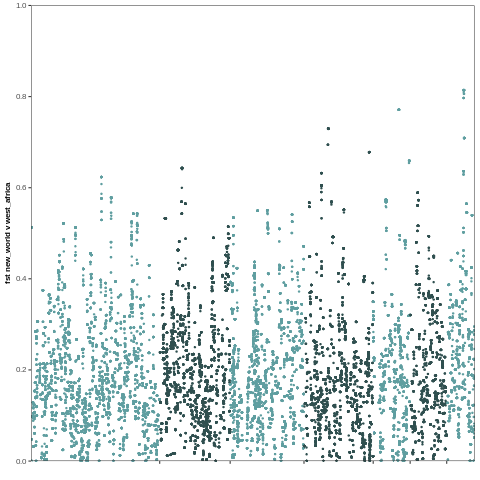

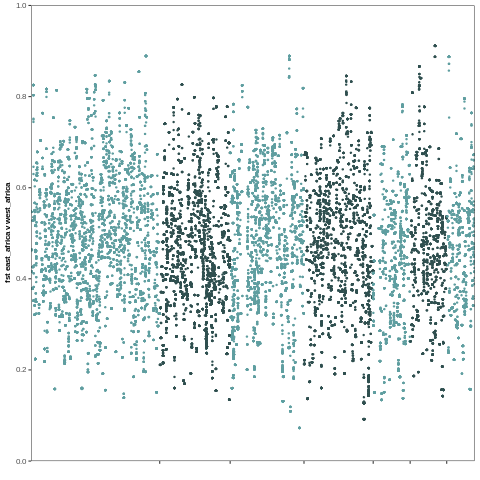

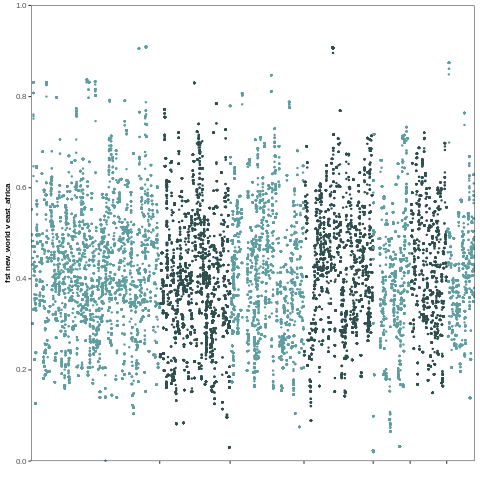

In [95]:
%%R

smoothed_k<-21

fst_plots<-vector("list", 3)
names(fst_plots)<-c("new_world_v_west_africa", "east_africa_v_west_africa", "new_world_v_east_africa")

#smooth the hs for each chromosome and output a single smoothed file
comps<-list()
comps[[1]]<-c("new_world",   "west_africa") 
comps[[2]]<-c("east_africa", "west_africa")
comps[[3]]<-c("new_world",   "east_africa")

for (comp in comps){
     pop1<-comp[1]
     pop2<-comp[2]

    #make input and output file names
    in_file  <- paste("results/fst_per_window/", pop1, "_vs_", pop2, "_fst_+-50kb.csv",  sep="")

    out <- paste("results/fst_per_window/", pop1, "_vs_", pop2, "_fst_+-50kb_smoothed", smoothed_k,  sep="")
    
    out_csv      <- paste(out, ".csv", sep="")
    out_png      <- paste(out, ".png", sep="")
    out_svg      <- paste(out, ".svg", sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")

    fst_table <- read.table(in_file, header=TRUE, sep=",")

    #get only complete cases
    fst_table <-fst_table[complete.cases(fst_table), ]

    pop_smoothed_fsts    <- c()

    #seperate out chromosomes
    for ( CHROM in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
        chr_start <- min(which(fst_table$chrom == CHROM))
        chr_stop  <- max(which(fst_table$chrom == CHROM))

        #get chr fst
        chr_fst    <- fst_table$fst[chr_start:chr_stop]

        #smooth
        smoothed_chr_fst    <-runmed(chr_fst, smoothed_k, endrule="median")

        #add to list
        pop_smoothed_fsts    <- c(pop_smoothed_fsts, smoothed_chr_fst)

    }

    #save to file
    fst_table$smoothed_fst    <- pop_smoothed_fsts

    write.csv(fst_table, 
              out_csv, 
              row.names = FALSE,
              quote     = FALSE)

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(fst_table$chrom, fst_table$pos)

    p <- ggplot(fst_table, 
                aes(x     = !!cumul_pos, 
                    y     = smoothed_fst, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("fst", pop1, "v", pop2, sep=" "), 
                                expand = c(0,0),
                                limits = c(0, 1),
                                breaks = seq(0,1,0.2),
                                labels = scales::number_format(accuracy = 0.1, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")
    
    #save the figure
    fst_plots[[paste(pop1, "v", pop2, sep="_")]]<-p
    
    ggsave(out_png, plot = p, dpi = 600)
    ggsave(out_svg, plot = p)
    ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

    #==================================================================================
    ##print to NB
    print(p)
}


### PBS

In [96]:
if os.path.isdir("results/pbs"):
    shutil.rmtree("results/pbs")
os.mkdir("results/pbs")

In [97]:
#snp_window_size
k=100

for comp in [ ["new_world",   "west_africa", "east_africa"] ]:

    pop_1 = comp[0]
    pop_2 = comp[1]
    pop_3 = comp[2]
    
    #clean pbs dict
    pbs_s=[]

    #cycle through each chromosome
    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
        
        #get the chrom ac for each pop
        start_pos = int(start_chr_idxs[chr]) 
        stop_pos  = int(stop_chr_idxs[chr])
        
        chr_pop_1_ac = pop_ac[pop_1][start_pos:stop_pos+1]
        chr_pop_2_ac = pop_ac[pop_2][start_pos:stop_pos+1]
        chr_pop_3_ac = pop_ac[pop_3][start_pos:stop_pos+1]
       
        #calc pbs
        pbs = allel.pbs(chr_pop_1_ac, 
                        chr_pop_2_ac, 
                        chr_pop_3_ac, 
                        window_size=k, 
                        window_step=1, 
                        normed=True)

        #add to a single list
        pbs_s = pbs_s + list(pbs) + ["nan"] * (k - 1) 

        
    #save list to a file (maybe plot)
    file_name = "results/pbs/new_world_vs_west_africa_vs_east_africa_pbs_" + str(k) + "-snp-window.csv"
    with open(file_name, 'w') as pbs_file:
        i = 0
        
        pbs_file.write("chrom,pos,pbsn1\n")
        
        while i < len(idx):
            out_line = "{chrom},{pos},{pbs}\n".format( chrom = chrom[i],
                                                       pos   = str(pos[i]),
                                                       pbs   = pbs_s[i])
            pbs_file.write(out_line)
            i = i + 1

/master/nplatt/anaconda3/envs/sch_man_nwinvasion-selection/lib/python3.7/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



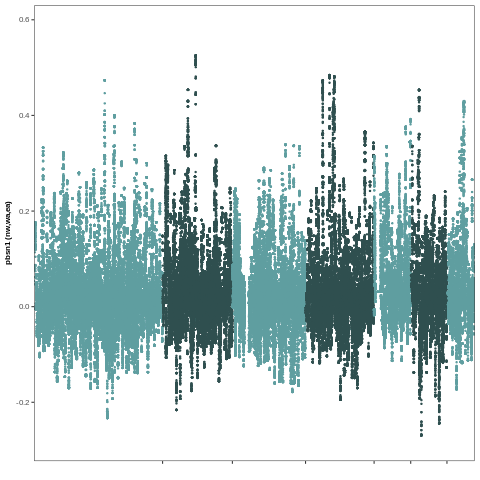

In [98]:
%%R

k<-100
smoothed_k<-21

#make input and output file names
in_file  <- paste("results/pbs/new_world_vs_west_africa_vs_east_africa_pbs_", k, "-snp-window.csv", sep="")

out <- paste("results/pbs/new_world_vs_west_africa_vs_east_africa_pbs_", k, "-snp-window_smoothed", smoothed_k, sep="")

out_csv      <- paste(out, ".csv", sep="")
out_png      <- paste(out, ".png", sep="")
out_svg      <- paste(out, ".svg", sep="")
out_slim_png <- paste(out, "_slim.png", sep="")

pbs_table <- read.table(in_file, header=TRUE, sep=",")

#get only complete cases
pbs_table <-pbs_table[complete.cases(pbs_table), ]

pop_smoothed_pbss    <- c()

#seperate out chromosomes
for ( CHROM in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
    chr_start <- min(which(pbs_table$chrom == CHROM))
    chr_stop  <- max(which(pbs_table$chrom == CHROM))

    #get chr h1
    chr_pbs   <- pbs_table$pbsn1[chr_start:chr_stop]

    #smooth
    smoothed_chr_pbs    <-runmed(chr_pbs, smoothed_k, endrule="median")

    #add to list
    pop_smoothed_pbss    <- c(pop_smoothed_pbss, smoothed_chr_pbs)

}

#save to file
pbs_table$smoothed_pbs    <- pop_smoothed_pbss

write.csv(pbs_table, 
          out_csv, 
          row.names = FALSE,
          quote = FALSE)

#plot----------------------------------------------------------------------------
cumul_pos<-get_cumul_pos(pbs_table$chrom, pbs_table$pos)

p <- ggplot(pbs_table, 
            aes(x     = !!cumul_pos, 
                y     = smoothed_pbs, 
                color = chrom))
#adjust colors
p <- p + scale_colour_manual(values = chr_colors)

#plot data
p <- p + geom_point(size = 0.5)

#modify x and y axis
p <- p + scale_x_continuous(name   = "", 
                            breaks = cumul_starts, 
                            expand = c(0,0))
p <- p + scale_y_continuous(name   = "pbsn1 (nw,wa,ea)", 
                            expand = c(0,0),
                            limits = c(min(pbs_table$smoothed_pbs) * 1.2,
                                       max(pbs_table$smoothed_pbs) * 1.2),
                            breaks = seq(-1,1,0.2),
                            labels = scales::number_format(accuracy = 0.1, 
                                                           decimal.mark = '.')
                           )

# #change theme
p <- p + theme_bw()

#change fonts on axis elements and titles
p <- p + theme(axis.text   = element_text(size = 8),
               axis.title  = element_text(size = 8,
                                          face = "bold"),
               axis.text.x = element_blank())

#removing gridlines
p <- p + theme(panel.grid.major = element_blank(), 
               panel.grid.minor = element_blank())

#modify legend
p <- p + theme(legend.position = "none")

#save the figure
pbs_plot<-p

ggsave(out_png, plot = p, dpi = 600)
ggsave(out_svg, plot = p)
ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

#print to NB
print(p)



### xpEHH

In [99]:
if os.path.isdir("results/xpehh"):
    shutil.rmtree("results/xpehh")
os.mkdir("results/xpehh")

Calculate xpehh from the previously stored haplotype arrays.  prints to csv file that can be imported/plotted in R

In [100]:
#list of population comparisons for xpehh
comp = [ [ "new_world",   "west_africa" ],
         [ "east_africa", "west_africa" ],
         [ "new_world",   "east_africa" ] ]

#make comparisons between population
for pops in comp:
    pop1 = pops[0]
    pop2 = pops[1]
    
    #clean pbs dict
    xpehh_s  = []
    sxpehh_s = []

    #cycle through each chromosome
    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
        
        #get the chrom ac for each pop
        start_pos = int(start_chr_idxs[chr]) 
        stop_pos  = int(stop_chr_idxs[chr]) + 1
        
        #subset from larger haplotype and pos arrays
        pop_1_chr_h = pop_h[pop1][start_pos:stop_pos]
        pop_2_chr_h = pop_h[pop2][start_pos:stop_pos]

        #get chrom positions
        chr_pos   = pos[start_pos:stop_pos]
        
        #xpehh
        xpehh=allel.xpehh(pop_1_chr_h, 
                          pop_2_chr_h, 
                          chr_pos,
                          map_pos       = None,
                          min_ehh       = 0.05,
                          include_edges = False, 
                          gap_scale     = 20_000, 
                          max_gap       = 200_000, 
                          is_accessible = None,
                          use_threads   = True)
                
        #standardize xpehh
        sxpehh=allel.standardize(xpehh)
        
        #add to a single list
        xpehh_s  = xpehh_s  + list(xpehh) 
        sxpehh_s = sxpehh_s + list(sxpehh) 

    #save list to a file (maybe plot)
    file_name = "results/xpehh/" + pop1 + "_vs_" + pop2 + "_xpehh.csv"
    with open(file_name, 'w') as xpehh_file:
        i = 0
        
        xpehh_file.write("chrom,pos,xpehh,sxpehh\n")
        
        while i < len(idx):
            out_line = "{chrom},{pos},{xpehh},{sxpehh}\n".format( chrom  = chrom[i],
                                                                  pos    = str(pos[i]),
                                                                  xpehh  = str(xpehh_s[i]),
                                                                  sxpehh = str(sxpehh_s[i]) )
            xpehh_file.write(out_line)
            i = i + 1

In [101]:
%%R

smoothed_k<-21

xpehh_plots<-vector("list", 3)
names(xpehh_plots)<-c("new_world_v_west_africa", "east_africa_v_west_africa", "new_world_v_east_africa")

#smooth the hs for each chromosome and output a single smoothed file
comps<-list()
comps[[1]]<-c("new_world",   "west_africa") 
comps[[2]]<-c("east_africa", "west_africa")
comps[[3]]<-c("new_world",   "east_africa")


for (comp in comps){
     pop1<-comp[1]
     pop2<-comp[2]

    #make input and output file names
    in_file  <- paste("results/xpehh/", pop1, "_vs_", pop2, "_xpehh.csv", sep="")

    out  <- paste("results/xpehh/", pop1,  "_vs_",  pop2,  "_xpehh_smoothed", smoothed_k, sep="")
    
    out_csv      <- paste(out, ".csv", sep="")
    out_png      <- paste(out, ".png", sep="")
    out_svg      <- paste(out, ".svg", sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")

    xpehh_table <- read.table(in_file, header=TRUE, sep=",")

    #get only complete cases
    xpehh_table <-xpehh_table[complete.cases(xpehh_table), ]

    pop_smoothed_xpehhs    <- c()

    #seperate out chromosomes
    for ( CHROM in c("SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7") ){
        chr_start <- min(which(xpehh_table$chrom == CHROM))
        chr_stop  <- max(which(xpehh_table$chrom == CHROM))

        #get chr xpehh
        chr_xpehh    <- xpehh_table$sxpehh[chr_start:chr_stop]

        #smooth
        smoothed_chr_xpehh    <-runmed(chr_xpehh,    smoothed_k, endrule="median")

        #add to list
        pop_smoothed_xpehhs    <- c(pop_smoothed_xpehhs, smoothed_chr_xpehh)

    }

    #save to file
    xpehh_table$smoothed_sxpehh    <- pop_smoothed_xpehhs

    write.csv(xpehh_table, 
              out_csv, 
              row.names = FALSE,
              quote     = FALSE)

    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(xpehh_table$chrom, xpehh_table$pos)

    p <- ggplot(xpehh_table, 
                aes(x     = !!cumul_pos, 
                    y     = smoothed_sxpehh, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("xpehh", pop1, "vs", pop2, sep=" "),
                                expand = c(0,0),
                                limits = c(min(xpehh_table$smoothed_sxpehh) * 1.2,
                                           max(xpehh_table$smoothed_sxpehh) * 1.2),
                                breaks = seq(-10,10,2),
                                labels = scales::number_format(accuracy = 0.1, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    xpehh_plots[[paste(pop1, "v", pop2, sep="_")]]<-p
    
    ggsave(out_png, plot = p, dpi = 600)
    ggsave(out_svg, plot = p)
    ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

    ##==================================================================================
    ##print to NB
    #print(p)
}


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



R[write to console]: Saving 6.67 x 6.67 in image



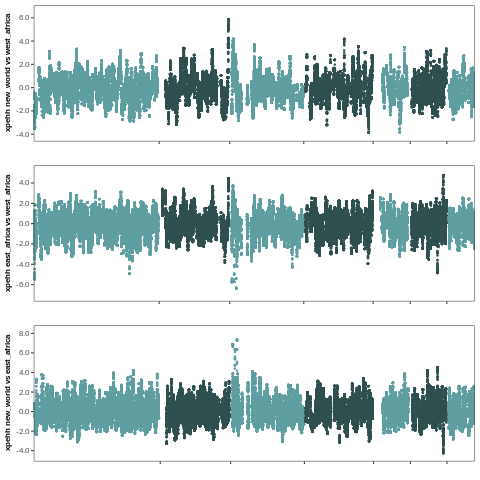

In [102]:
%%R

plot <- ggarrange(plotlist = xpehh_plots, 
                  ncol = 1, 
                  nrow = 3)

print(plot)

ggsave("results/xpehh/combined.png", plot = plot, dpi = 1200)


## DCMS

In [107]:
if os.path.isdir("results/dcms"):
    shutil.rmtree("results/dcms")
os.mkdir("results/dcms")

### Merging Data

In [120]:
cols = [ "chrom",           "pos",                 "window_start_x",
         "window_stop_x",   "n_accessible_bases",  "snp_count_x",
         "pi",              "smoothed_pi",         "tajimasd",
         "smoothed_td",     "h1",                  "h12",
         "h123",            "h2_h1",               "smoothed_h1",
         "smoothed_h12",    "smoothed_h123",       "smoothed_h2_h1",
         "sihs",            "smoothed_ihs",        "fst",            
         "smoothed_fst",    "xpehh",               "sxpehh",
         "smoothed_sxpehh", "pbsn1",               "smoothed_pbs" ]

In [121]:
#get nw_vs_ea file
pi_infile    = "results/pi_per_window/new_world_pi_+-50kb_smoothed21.csv"
td_infile    = "results/tajimas_d/new_world_tajimas-d_+-50kb_smoothed21.csv"
h_infile     = "results/garuds_h/new_world_garuds-h_100-snp-window_smoothed21.csv"
ihs_infile   = "results/ihs/new_world_ihs_smoothed21.csv"
fst_infile   = "results/fst_per_window/new_world_vs_west_africa_fst_+-50kb_smoothed21.csv"
xpehh_infile = "results/xpehh/new_world_vs_west_africa_xpehh_smoothed21.csv"
pbs_infile   = "results/pbs/new_world_vs_west_africa_vs_east_africa_pbs_100-snp-window_smoothed21.csv"

pi_table    = pd.read_csv(pi_infile)
td_table    = pd.read_csv(td_infile)
h_table     = pd.read_csv(h_infile)
ihs_table   = pd.read_csv(ihs_infile)
fst_table   = pd.read_csv(fst_infile)
xpehh_table = pd.read_csv(xpehh_infile)
pbs_table   = pd.read_csv(pbs_infile)

merged_table = pd.merge(pi_table,     td_table,    on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, h_table,     on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, ihs_table,   on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, fst_table,   on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, xpehh_table, on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, pbs_table,   on=["chrom", "pos"], how='outer')

trimmed_table = merged_table[cols]
trimmed_table.to_csv('results/dcms/nw_vs_wa.csv', na_rep="NaN", index=False)


In [113]:
#get ea_vs_wa file
pi_infile    = "results/pi_per_window/west_africa_pi_+-50kb_smoothed21.csv"
td_infile    = "results/tajimas_d/west_africa_tajimas-d_+-50kb_smoothed21.csv"
h_infile     = "results/garuds_h/west_africa_garuds-h_100-snp-window_smoothed21.csv"
ihs_infile   = "results/ihs/west_africa_ihs_smoothed21.csv"
fst_infile   = "results/fst_per_window/east_africa_vs_west_africa_fst_+-50kb_smoothed21.csv"
xpehh_infile = "results/xpehh/east_africa_vs_west_africa_xpehh_smoothed21.csv"
pbs_infile   = "results/pbs/new_world_vs_west_africa_vs_east_africa_pbs_100-snp-window_smoothed21.csv"

pi_table    = pd.read_csv(pi_infile)
td_table    = pd.read_csv(td_infile)
h_table     = pd.read_csv(h_infile)
ihs_table   = pd.read_csv(ihs_infile)
fst_table   = pd.read_csv(fst_infile)
xpehh_table = pd.read_csv(xpehh_infile)
pbs_table   = pd.read_csv(pbs_infile)

merged_table = pd.merge(pi_table,     td_table,    on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, h_table,     on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, ihs_table,   on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, fst_table,   on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, xpehh_table, on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, pbs_table,   on=["chrom", "pos"], how='outer')

trimmed_table = merged_table[cols]
trimmed_table.to_csv('results/dcms/ea_vs_wa.csv', na_rep="NaN", index=False)


In [114]:
#get nw_vs_ea file
pi_infile    = "results/pi_per_window/new_world_pi_+-50kb_smoothed21.csv"
td_infile    = "results/tajimas_d/new_world_tajimas-d_+-50kb_smoothed21.csv"
h_infile     = "results/garuds_h/new_world_garuds-h_100-snp-window_smoothed21.csv"
ihs_infile   = "results/ihs/new_world_ihs_smoothed21.csv"
fst_infile   = "results/fst_per_window/new_world_vs_east_africa_fst_+-50kb_smoothed21.csv"
xpehh_infile = "results/xpehh/new_world_vs_east_africa_xpehh_smoothed21.csv"
pbs_infile   = "results/pbs/new_world_vs_west_africa_vs_east_africa_pbs_100-snp-window_smoothed21.csv"

pi_table    = pd.read_csv(pi_infile)
td_table    = pd.read_csv(td_infile)
h_table     = pd.read_csv(h_infile)
ihs_table   = pd.read_csv(ihs_infile)
fst_table   = pd.read_csv(fst_infile)
xpehh_table = pd.read_csv(xpehh_infile)
pbs_table   = pd.read_csv(pbs_infile)

merged_table = pd.merge(pi_table,     td_table,    on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, h_table,     on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, ihs_table,   on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, fst_table,   on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, xpehh_table, on=["chrom", "pos"], how='outer')
merged_table = pd.merge(merged_table, pbs_table,   on=["chrom", "pos"], how='outer')

trimmed_table = merged_table[cols]
trimmed_table.to_csv('results/dcms/nw_vs_ea.csv', na_rep="NaN", index=False)


### Calc DCMS

Had a miserable time installing DCMS on remote.  Installed and run on local linux computer using info from https://github.com/NESCent/MINOTAUR and R 3.6.2.  In additition to dependencies, installed rrcovNA, MASS, and fitdistrplus.  Very miserable install.

In [ ]:
# library("dplyr")
# library("rrcovNA")
# library(MINOTAUR)
# library("MASS")
# library("fitdistrplus")

# setwd("C:/Users/rplatt/Dropbox (TX Biomed)/projects/sch_man_nwinvasion/results/dcms")

# #----------------------------------------------------------------------------------------------------------------------
# #   NEW WORLD VS EAST AFRICA
# #----------------------------------------------------------------------------------------------------------------------
# #read in sel stats
# sel_table<-read.table("nw_vs_ea.csv", header=TRUE, sep=",")

# #for now only keep certain statistics
# keeps <- c("chrom", "pos", "smoothed_pi", "smoothed_td", "smoothed_ihs", "smoothed_h12", "smoothed_sxpehh")

# pi_rank<-percent_rank(sel_table$smoothed_pi)
# pi_norm<-qnorm((rank(pi_rank,na.last="keep")-0.5)/sum(!is.na(pi_rank)))
# pi_p<-pnorm(pi_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# td_rank<-percent_rank(sel_table$smoothed_td)
# td_norm<-qnorm((rank(td_rank,na.last="keep")-0.5)/sum(!is.na(td_rank)))
# td_p<-pnorm(td_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)

# abs_ihs<-abs(sel_table$smoothed_ihs)
# ihs_rank<-percent_rank(abs_ihs)
# ihs_norm<-qnorm((rank(ihs_rank,na.last="keep")-0.5)/sum(!is.na(ihs_rank)))
# ihs_p<-pnorm(ihs_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# h12_rank<-percent_rank(sel_table$smoothed_h12)
# h12_norm<-qnorm((rank(h12_rank,na.last="keep")-0.5)/sum(!is.na(h12_rank)))
# h12_p<-pnorm(h12_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)

# abs_sxpehh<-abs(sel_table$smoothed_sxpehh)
# xpehh_rank<-percent_rank(abs_sxpehh)
# xpehh_norm<-qnorm((rank(xpehh_rank,na.last="keep")-0.5)/sum(!is.na(xpehh_rank)))
# xpehh_p<-pnorm(xpehh_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# dfp<-data.frame(pi_p, td_p, ihs_p, h12_p, xpehh_p)

# #for now only keep certain statistics
# dfv<-sel_table[keeps]
# dfv<-na.omit(dfv)
# dfp<-na.omit(dfp)

# #calculate a cov matrix on the pvalues
# cov_matrix<-CovNAMcd(dfp, alpha = 0.75, nsamp = 100000)

# #decorelatced composite test
# dcms<-DCMS(dfv, 
#            subset = 1:nrow(dfv),
#            S=cov_matrix$cov,
#            column.nums=3:7,
#            dfp,
#            column.nums.p =1:5
# )

# plot(dcms,
#      pch=19,
#      cex=0.5,
#      col="blue"
#      )

# out_data<-data.frame(dfv, dfp, dcms)

# write.csv(out_data, "nw_vs_ea_dcms.csv", row.names=FALSE, quote=FALSE)

# #make bed
# sig_quantile<-quantile(out_data$dcms, 0.995)
# sig_snps<-subset(out_data, dcms >= sig_quantile)
# cols<-c("chrom", "pos", "pos")
# sig_snps<-sig_snps[cols]
# write.table(sig_snps, "nw_vs_ea_dcms_sig.bed", sep="\t", row.names=FALSE, quote=FALSE)


# #----------------------------------------------------------------------------------------------------------------------
# #   WEST AFRICA VS EAST AFRICA
# #----------------------------------------------------------------------------------------------------------------------
# #read in sel stats
# sel_table<-read.table("wa_vs_ea.csv", header=TRUE, sep=",")

# #for now only keep certain statistics
# keeps <- c("chrom", "pos", "smoothed_pi", "smoothed_td", "smoothed_ihs", "smoothed_h12", "smoothed_sxpehh")

# pi_rank<-percent_rank(sel_table$smoothed_pi)
# pi_norm<-qnorm((rank(pi_rank,na.last="keep")-0.5)/sum(!is.na(pi_rank)))
# pi_p<-pnorm(pi_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# td_rank<-percent_rank(sel_table$smoothed_td)
# td_norm<-qnorm((rank(td_rank,na.last="keep")-0.5)/sum(!is.na(td_rank)))
# td_p<-pnorm(td_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)

# abs_ihs<-abs(sel_table$smoothed_ihs)
# ihs_rank<-percent_rank(abs_ihs)
# ihs_norm<-qnorm((rank(ihs_rank,na.last="keep")-0.5)/sum(!is.na(ihs_rank)))
# ihs_p<-pnorm(ihs_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# h12_rank<-percent_rank(sel_table$smoothed_h12)
# h12_norm<-qnorm((rank(h12_rank,na.last="keep")-0.5)/sum(!is.na(h12_rank)))
# h12_p<-pnorm(h12_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)

# ##### VERY IMPROTANT TAIL CHANGE
# abs_sxpehh<-abs(sel_table$smoothed_sxpehh)
# xpehh_rank<-percent_rank(abs_sxpehh)
# xpehh_norm<-qnorm((rank(xpehh_rank,na.last="keep")-0.5)/sum(!is.na(xpehh_rank)))
# xpehh_p<-pnorm(xpehh_norm, mean = 0, sd = 2, lower.tail = TRUE, log.p = FALSE)


# dfp<-data.frame(pi_p, td_p, ihs_p, h12_p, xpehh_p)

# #for now only keep certain statistics
# dfv<-sel_table[keeps]
# dfv<-na.omit(dfv)
# dfp<-na.omit(dfp)

# #calculate a cov matrix on the pvalues
# cov_matrix<-CovNAMcd(dfp, alpha = 0.75, nsamp = 100000)

# #decorelatced composite test
# dcms<-DCMS(dfv, 
#            subset = 1:nrow(dfv),
#            S=cov_matrix$cov,
#            column.nums=3:7,
#            dfp,
#            column.nums.p =1:5
# )

# plot(dcms,
#      pch=19,
#      cex=0.5,
#      col="green"
# )

# out_data<-data.frame(dfv, dfp, dcms)

# write.csv(out_data, "wa_vs_ea_dcms.csv", row.names=FALSE, quote=FALSE)

# #make bed
# sig_quantile<-quantile(out_data$dcms, 0.995)
# sig_snps<-subset(out_data, dcms >= sig_quantile)
# cols<-c("chrom", "pos", "pos")
# sig_snps<-sig_snps[cols]
# write.table(sig_snps, "wa_vs_ea_dcms_sig.bed", sep="\t", row.names=FALSE, quote=FALSE)


# #----------------------------------------------------------------------------------------------------------------------
# #   NEW WORLD VS WEST AFRICA
# #----------------------------------------------------------------------------------------------------------------------
# #read in sel stats
# sel_table<-read.table("nw_vs_wa.csv", header=TRUE, sep=",")

# #for now only keep certain statistics
# keeps <- c("chrom", "pos", "smoothed_pi", "smoothed_td", "smoothed_ihs", "smoothed_h12", "smoothed_sxpehh")

# pi_rank<-percent_rank(sel_table$smoothed_pi)
# pi_norm<-qnorm((rank(pi_rank,na.last="keep")-0.5)/sum(!is.na(pi_rank)))
# pi_p<-pnorm(pi_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# td_rank<-percent_rank(sel_table$smoothed_td)
# td_norm<-qnorm((rank(td_rank,na.last="keep")-0.5)/sum(!is.na(td_rank)))
# td_p<-pnorm(td_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)

# abs_ihs<-abs(sel_table$smoothed_ihs)
# ihs_rank<-percent_rank(abs_ihs)
# ihs_norm<-qnorm((rank(ihs_rank,na.last="keep")-0.5)/sum(!is.na(ihs_rank)))
# ihs_p<-pnorm(ihs_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# h12_rank<-percent_rank(sel_table$smoothed_h12)
# h12_norm<-qnorm((rank(h12_rank,na.last="keep")-0.5)/sum(!is.na(h12_rank)))
# h12_p<-pnorm(h12_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)

# abs_sxpehh<-abs(sel_table$smoothed_sxpehh)
# xpehh_rank<-percent_rank(abs_sxpehh)
# xpehh_norm<-qnorm((rank(xpehh_rank,na.last="keep")-0.5)/sum(!is.na(xpehh_rank)))
# xpehh_p<-pnorm(xpehh_norm, mean = 0, sd = 2, lower.tail = FALSE, log.p = FALSE)


# dfp<-data.frame(pi_p, td_p, ihs_p, h12_p, xpehh_p)

# #for now only keep certain statistics
# dfv<-sel_table[keeps]
# dfv<-na.omit(dfv)
# dfp<-na.omit(dfp)

# #calculate a cov matrix on the pvalues
# cov_matrix<-CovNAMcd(dfp, alpha = 0.75, nsamp = 100000)

# #decorelatced composite test
# dcms<-DCMS(dfv, 
#            subset = 1:nrow(dfv),
#            S=cov_matrix$cov,
#            column.nums=3:7,
#            dfp,
#            column.nums.p =1:5
# )

# plot(dcms,
#      pch=19,
#      cex=0.5,
#      col="blue"
# )

# out_data<-data.frame(dfv, dfp, dcms)

# write.csv(out_data, "nw_vs_wa_dcms.csv", row.names=FALSE, quote=FALSE)

# #make bed
# sig_quantile<-quantile(out_data$dcms, 0.995)
# sig_snps<-subset(out_data, dcms >= sig_quantile)
# cols<-c("chrom", "pos", "pos")
# sig_snps<-sig_snps[cols]
# write.table(sig_snps, "nw_vs_wa_dcms_sig.bed", sep="\t", row.names=FALSE, quote=FALSE)

### Figure

In [122]:
%%R

#smooth the hs for each chromosome and output a single smoothed file
comps<-list()
comps[[1]]<-c("nw", "ea") 
comps[[2]]<-c("wa", "ea")
comps[[3]]<-c("nw", "wa")

dcms_plots<-vector("list", 3)
names(dcms_plots)<-c("nw_v_ea",
                     "wa_v_ea",
                     "nw_v_wa" )

for (comp in comps){
     pop1<-comp[1]
     pop2<-comp[2]

    #make input and output file names
    in_file  <- paste("results/dcms/", pop1, "_vs_", pop2, "_dcms.csv", sep="")

    out  <- paste("results/dcms/", pop1,  "_vs_",  pop2,  "_dcms", sep="")

    out_png      <- paste(out, ".png", sep="")
    out_svg      <- paste(out, ".svg", sep="")
    out_slim_png <- paste(out, "_slim.png", sep="")

    dcms_table <- read.table(in_file, header=TRUE, sep=",")


    #plot----------------------------------------------------------------------------
    cumul_pos<-get_cumul_pos(dcms_table$chrom, dcms_table$pos)

    p <- ggplot(dcms_table, 
                aes(x     = !!cumul_pos, 
                    y     = dcms, 
                    color = chrom))
    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(size = 0.5)

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("DCMS", pop1, "vs", pop2, sep=" "),
                                expand = c(0,0),
                                limits = c(min(dcms_table$dcms) * 1.2,
                                           max(dcms_table$dcms) * 1.2),
                                breaks = seq(-15,15,1),
                                labels = scales::number_format(accuracy = 0.1, 
                                                               decimal.mark = '.')
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 8),
                   axis.title  = element_text(size = 8,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major = element_blank(), 
                   panel.grid.minor = element_blank())

    #modify legend
    p <- p + theme(legend.position = "none")
    
    #add horizonal line at 0.995
    p <- p + geom_hline(yintercept = quantile(dcms_table$dcms,0.995), 
                linetype   = "dashed", 
                color      = "red")
    

    #save the figure
    dcms_plots[[paste(pop1, "v", pop2, sep="_")]]<-p
    
     ggsave(out_png, plot = p, dpi = 600)
     ggsave(out_svg, plot = p)
     ggsave(out_slim_png, plot = p, dpi = 600, height = 2, width = 7)

#     #==================================================================================
#     #print to NB
#     print(p)
}


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



R[write to console]: Saving 6.67 x 6.67 in image



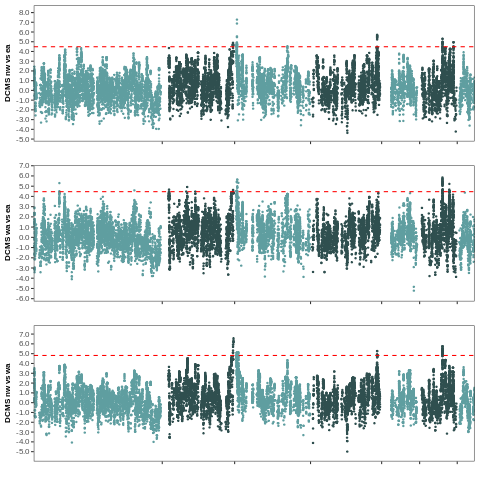

In [123]:
%%R

plot <- ggarrange(plotlist = dcms_plots, 
                  ncol = 1, 
                  nrow = 3)

print(plot)

ggsave("results/dcms/combined.png", plot = plot, dpi = 1200)

In [ ]:
%%R
#dcms_table[dcms_table$dcms>=quantile(dcms_table$dcms,0.995), ]

sig=quantile(dcms_table$dcms, 0.995)
sig_snps <- subset(dcms_table, dcms >= sig)
sig_snps

## Tables

## Figures

## Unused code snippets

In [ ]:
%%R

#adding lines to plots
#===================================================================================
# #add horizontal line at 99.5th Zscore and 2
p <- p + geom_hline(yintercept = 3, 
                linetype   = "dashed",
                color      = "red")
p <- p + geom_hline(yintercept = -2, 
                linetype   = "dashed", 
                color      = "red")
p <- p + geom_hline(yintercept = quantile(abs(ihs_df$normIHS), 0.995, na.rm=TRUE), 
                linetype   = "dashed", 
                color      = "green")

#modifying titles
p <- p + ggtitle(pop)
p <- p + theme(plot.title = element_text(hjust = 0.5, 
                                         vjust = 0.5, 
                                         face  = 'bold', 
                                         size  = 18))

#add smoothin and window info
p <- p + annotate("text", 
                  x     = 5e6, 
                  y     = max(td_table$smoothed_td)*1.15, 
                  label = paste("window=", k, "; smooth=", smoothed_k, sep=""), 
                  color = "black",
                  hjust = 0)